In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
from scipy.optimize import curve_fit
import h5py
from pathlib import Path    
from collections.abc import Iterable

In [2]:
datapath = Path.cwd() / "results/short_times"

In [3]:
def rearrange_data(arr): #
    res = np.swapaxes(arr,-1,0)
    res = np.swapaxes(res,-2,1)
    return res

def disorder_mean(A, n_samples = None):
    if n_samples is None:
        return np.mean(A,2)
    else:
        return np.mean(A[:,:,0:n_samples],2)

def disorder_std(A, n_samples = None):
    if n_samples is None:
        return np.std(A,2)
    else:
        return np.std(A[:,:,0:n_samples],2)

In [4]:
def idx_transgression(arr,threshold):
    idx = np.zeros(arr.shape[1],dtype=int)
    for j in range(arr.shape[1]):
        found = False
        for i in range(arr.shape[0]):
            if found == False and arr[i,j] >= threshold:
                idx[j] = i
                found = True
        if found == False:
            idx[j] = -1 #be careful that this never breaks things
    return idx

def safeguard_minusone(idx):
    res = np.zeros(idx.shape[0],dtype=float)
    for i in range(idx.shape[0]):
        res[i] = idx[i] if idx[i] != -1 else np.nan
    return res

def mask_transgression(arr,threshold):
    mask = np.zeros(arr.shape,dtype=bool)
    idx = idx_transgression(arr,threshold)
    for j in range(arr.shape[1]):
        if idx[j] != -1:
            mask[idx[j],j]=True
    return mask

def T_transgression(T,arr,threshold):
    idx = idx_transgression(arr,threshold)
    t_past = T[idx]
    t_before = T[[i-1 if i > 0 else 0 for i in idx]]
    arr_past = np.zeros(arr.shape[1])
    arr_before = np.zeros(arr.shape[1])
    t_th = np.zeros(arr.shape[1])
    for j in range(0,arr.shape[1]):
        arr_past[j] = arr[idx[j],j]
        arr_before[j] = arr[idx[j]-1 if idx[j] > 0 else 0,j]

        t_th[j] = (threshold-arr_before[j])/(arr_past[j]-arr_before[j]) * (t_past[j]-t_before[j]) + t_before[j]
    return t_th

In [58]:
jobids = []
params = []
data = []
N = 17
folders = [datapath/"h=0",datapath/"h=0.5",datapath/"h=1",datapath/"h=1.5",datapath/"h=2",datapath/"h=2.5",datapath/"h=3"]
files = ["5520873_N17_FD.jld2","5568753-5568754_N17.jld2",]
for (i,file) in enumerate(files):
    with h5py.File(folders[i]/file,"r") as f:
        if i == 0:
            jobids.append(f["jobid"][()].decode("UTF-8"))
            data.append(2-2*rearrange_data(f["data"][()]))
            params.append(f["params"][()])
        else:
            jobids.append(list(map(lambda s: s.decode("UTF-8"),f["jobid"][()])))
            data.append(2-2*np.array([rearrange_data(f[f["data"][l]]) for l in range(len(f["data"]))]))
            params.append(list(f[f["params"][l]][()] for l in range(len(f["params"]))))
for  i in range(0,1):
        data[i] = np.concatenate(data[i],axis=2)
T = np.arange(0,2.01,0.01)
xcenter = N//2

In [43]:
data[0].shape

(201, 17, 100)

In [44]:
res = list(map(lambda arr: disorder_mean(arr),data))
res_err = list(map(lambda arr: disorder_std(arr),data))

In [45]:
xvals = np.array([abs(pos-xcenter) for pos in range(1,N+1)])

In [49]:
def model(x,a,b,c):
    return a*x**b+c

## h=0.5

In [65]:
idh = 0

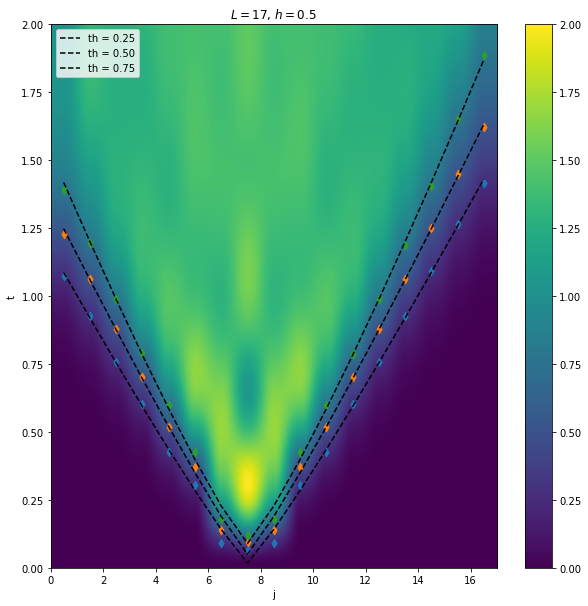

In [66]:
thresholds = [0.25,0.5,0.75]#,1.25,1.5,1.75,2]
fit_params = []
fit_errs = []
tvals = []
for (i,th) in enumerate(thresholds):
    tvals.append(T_transgression(T,res[idh],th))
    popt, pcov = curve_fit(model,xvals,tvals[i])
    fit_params.append(popt)
    fit_errs.append(np.sqrt(np.diag(pcov)))
plt.figure(figsize=(10,10))
linestyles = ["-","--","-."]
plt.imshow(res[idh],cmap="viridis",origin="lower",aspect="auto",extent=[0,N,0,T[-1]])
for (i,th) in enumerate(thresholds):
    plt.plot(np.arange(0,N,1)+0.5,model(xvals,*fit_params[i]),label="th = {:.2f}".format(th),color="black",ls="--")
    plt.scatter(np.arange(0,N,1)+0.5,tvals[i], marker= "d")
plt.clim(0,2)
plt.colorbar()
plt.xlabel("j")
plt.ylabel("t")
plt.legend()
plt.title(r"$L=17$, $h=0.5$")
plt.show()

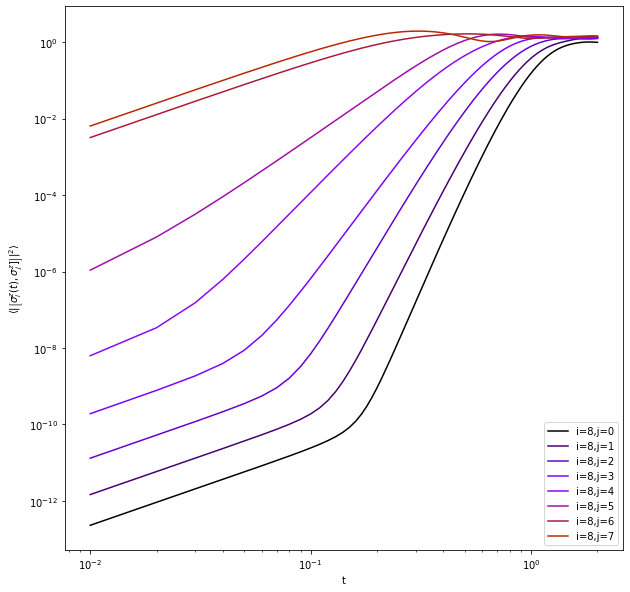

In [78]:
NUM_COLORS = N//2
cm = plt.get_cmap('gnuplot')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS+5)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS)])
for j in range(0,N//2):
    ax.loglog(T[1:],res[idh][1:,j],label="i={},j={}".format(N//2,j))
ax.legend(loc="lower right")
ax.set_xlabel("t")
ax.set_ylabel(r"$\langle\left|\left[\sigma_i^z(t),\sigma_j^z]\right]\right|^2\rangle$")
#ax.set_ylim(1e-12,5)
plt.show()

In [75]:
T

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  , 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09,
       1.1 , 1.11, 1.12, 1.13, 1.14, 1.15, 1.16, 1.17, 1.18, 1.19, 1.2 ,
       1.21, 1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3 , 1.31,
       1.32, 1.33, 1.34, 1.35, 1.36, 1.37, 1.38, 1.39, 1.4 , 1.41, 1.42,
       1.43, 1.44, 1.45, 1.46, 1.47, 1.48, 1.49, 1.

In [74]:
res[0][:,4]

array([3.33066907e-16, 6.26863935e-09, 3.39773444e-08, 1.53679056e-07,
       6.27568202e-07, 2.12099096e-06, 5.98792289e-06, 1.46201864e-05,
       3.18478154e-05, 6.33759890e-05, 1.17242411e-04, 2.04277949e-04,
       3.38552800e-04, 5.37790446e-04, 8.23732167e-04, 1.22243596e-03,
       1.76449525e-03, 2.48516470e-03, 3.42438307e-03, 4.62668545e-03,
       6.14100060e-03, 8.02033200e-03, 1.03213246e-02, 1.31037225e-02,
       1.64297262e-02, 2.03632602e-02, 2.49691654e-02, 3.03123320e-02,
       3.64567920e-02, 4.34647890e-02, 5.13958463e-02, 6.03058540e-02,
       7.02461929e-02, 8.12629164e-02, 9.33960048e-02, 1.06678710e-01,
       1.21137001e-01, 1.36789118e-01, 1.53645253e-01, 1.71707341e-01,
       1.90968983e-01, 2.11415484e-01, 2.33024010e-01, 2.55763847e-01,
       2.79596762e-01, 3.04477448e-01, 3.30354041e-01, 3.57168695e-01,
       3.84858204e-01, 4.13354647e-01, 4.42586062e-01, 4.72477109e-01,
       5.02949732e-01, 5.33923805e-01, 5.65317742e-01, 5.97049082e-01,
      

In [ ]:
T